# Weather Temperature Analysis

#### The analysis starts by removing cells that contain null values, and data recorded before Jan 1990. Plot of histogram of unadjusted data can be found in line 11 and the q-q plot that shows the distribution can be found in line 13

#### This is followed by excluding outliers (data points that are +- 3 standard deviations from mean), using both Z-Score and Adjusted Z-Score Methodology

#### The last part is about fitting the data into a normal distribution and determine the maximum temperature at 95th percentile. All three methodologies (log, x root and Box-Cox) produce data of 38.5 degrees celsius. You can find the summary at the bottom of this notebook.

## Import Packages

In [1]:
import numpy as np
from scipy import stats
from scipy.stats import shapiro, kstest
import pandas as pd
import math
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py

C:\Users\chris\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Import & Clean Data

In [2]:
raw_data=pd.read_csv('Australian_Gov_Weather.csv')
raw_data

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,86282,1970,1,1,NaN,NaN,NaN
1,IDCJAC0010,86282,1970,1,2,NaN,NaN,NaN
2,IDCJAC0010,86282,1970,1,3,NaN,NaN,NaN
3,IDCJAC0010,86282,1970,1,4,NaN,NaN,NaN
4,IDCJAC0010,86282,1970,1,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
19455,IDCJAC0010,86282,2023,4,8,17.1,1.0,N
19456,IDCJAC0010,86282,2023,4,9,15.2,1.0,N
19457,IDCJAC0010,86282,2023,4,10,15.5,1.0,N
19458,IDCJAC0010,86282,2023,4,11,19.4,1.0,N


In [3]:
# Remove irrelevant columns
raw_data.drop(raw_data.columns[[0,1,6,7]], axis=1, inplace=True)
raw_data

,Year,Month,Day,Maximum temperature (Degree C)
0,1970,1,1,NaN
1,1970,1,2,NaN
2,1970,1,3,NaN
3,1970,1,4,NaN
4,1970,1,5,NaN
...,...,...,...,...
19455,2023,4,8,17.1
19456,2023,4,9,15.2
19457,2023,4,10,15.5
19458,2023,4,11,19.4


In [4]:
# Remove rows with 'NaN'
raw_data.dropna(inplace=True)
raw_data

,Year,Month,Day,Maximum temperature (Degree C)
181,1970,7,1,14.1
182,1970,7,2,12.4
183,1970,7,3,11.3
184,1970,7,4,12.3
185,1970,7,5,14.8
...,...,...,...,...
19455,2023,4,8,17.1
19456,2023,4,9,15.2
19457,2023,4,10,15.5
19458,2023,4,11,19.4


In [5]:
# Filter out data before year 1990
raw_data = raw_data.loc[raw_data["Year"] >= 1990]
raw_data

,Year,Month,Day,Maximum temperature (Degree C)
7305,1990,1,1,23.0
7306,1990,1,2,32.8
7307,1990,1,3,39.0
7308,1990,1,4,20.2
7309,1990,1,5,24.8
...,...,...,...,...
19455,2023,4,8,17.1
19456,2023,4,9,15.2
19457,2023,4,10,15.5
19458,2023,4,11,19.4


In [6]:
# Extract January data only
raw_data = raw_data.loc[raw_data["Month"] == 1]
raw_data

,Year,Month,Day,Maximum temperature (Degree C)
7305,1990,1,1,23.0
7306,1990,1,2,32.8
7307,1990,1,3,39.0
7308,1990,1,4,20.2
7309,1990,1,5,24.8
...,...,...,...,...
19384,2023,1,27,28.9
19385,2023,1,28,34.9
19386,2023,1,29,23.9
19387,2023,1,30,21.9


In [7]:
# Rebase Index and set 01/01/1990 as the first day
raw_data.reset_index(inplace=True, drop=True)
raw_data

,Year,Month,Day,Maximum temperature (Degree C)
0,1990,1,1,23.0
1,1990,1,2,32.8
2,1990,1,3,39.0
3,1990,1,4,20.2
4,1990,1,5,24.8
...,...,...,...,...
1049,2023,1,27,28.9
1050,2023,1,28,34.9
1051,2023,1,29,23.9
1052,2023,1,30,21.9


In [8]:
# Calculate Mean
mean=raw_data['Maximum temperature (Degree C)'].mean()
mean

27.015464895635635

In [9]:
# Calculate Standard Deviation
standard_deviation=raw_data['Maximum temperature (Degree C)'].std()
standard_deviation

6.161247169830983

## Plotting Histogram

In [10]:
# Preparing data
plot_data = raw_data['Maximum temperature (Degree C)']
bins = [10,15,20,25,30,35,40,45,50]
ticks = list(range(13, 50, 1)) # Create a tick every 3 step(s)
plot_data.shape

(1054,)

([<matplotlib.axis.XTick at 0x1ff3c8bca48>,
 <a list of 37 Text xticklabel objects>)

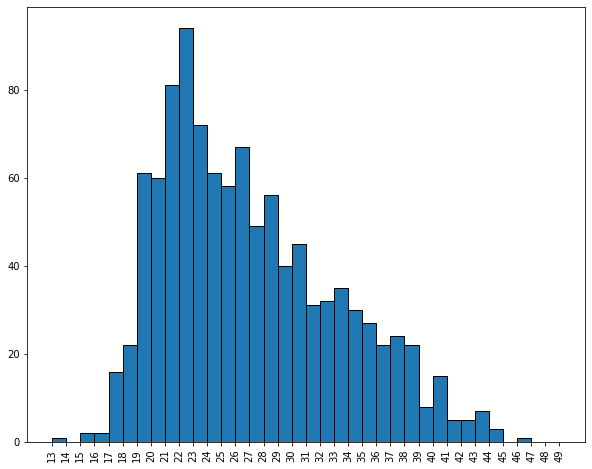

In [11]:
# Plot graph
plt.figure(figsize=(10,8))
plt.hist( plot_data, bins=ticks,edgecolor='black')
plt.xticks(ticks, rotation="vertical")

In [12]:
# Save it as a variable
unadj_data = plot_data

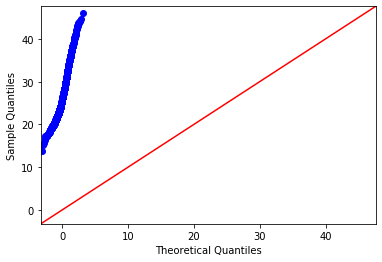

In [13]:
# QQ-Plot
sm.qqplot(plot_data, line ='45')
py.show()

## Data Cleaning - Z-Score Method

In [14]:
# Compute Summary Statistics for raw data set
raw_data['Maximum temperature (Degree C)'].describe()

count    1054.000000
mean       27.015465
std         6.161247
min        13.900000
25%        22.200000
50%        25.900000
75%        31.100000
max        46.000000
Name: Maximum temperature (Degree C), dtype: float64

In [15]:
raw_data['Z-Score'] = (raw_data['Maximum temperature (Degree C)'] - raw_data['Maximum temperature (Degree C)'].mean())/ \
                       raw_data['Maximum temperature (Degree C)'].std()
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Year,Month,Day,Maximum temperature (Degree C),Z-Score
0,1990,1,1,23.0,-0.651729
1,1990,1,2,32.8,0.938858
2,1990,1,3,39.0,1.945148
3,1990,1,4,20.2,-1.106183
4,1990,1,5,24.8,-0.359581
...,...,...,...,...,...
1049,2023,1,27,28.9,0.305869
1050,2023,1,28,34.9,1.279698
1051,2023,1,29,23.9,-0.505655
1052,2023,1,30,21.9,-0.830265


In [16]:
# Detecting outliers by looking at values with 3 standard deviations below or above mean of the sample
raw_data[(raw_data['Z-Score'] < -3) | (raw_data['Z-Score'] > 3)]

,Year,Month,Day,Maximum temperature (Degree C),Z-Score
923,2019,1,25,46.0,3.081281


In [17]:
# Since one outlier above mean has been identified, we are going to exclude it from the dataset
raw_data_no_outlier = raw_data[(raw_data['Z-Score'] > -3) & (raw_data['Z-Score'] < 3)]
raw_data_no_outlier.shape

(1053, 5)

In [18]:
# Preparing data
plot_data = raw_data_no_outlier['Maximum temperature (Degree C)']
bins = [10,15,20,25,30,35,40,45,50]
ticks = list(range(13, 50, 1)) # Create a tick every 3 step(s)
plot_data.shape

(1053,)

([<matplotlib.axis.XTick at 0x1ff3eac1d48>,
 <a list of 37 Text xticklabel objects>)

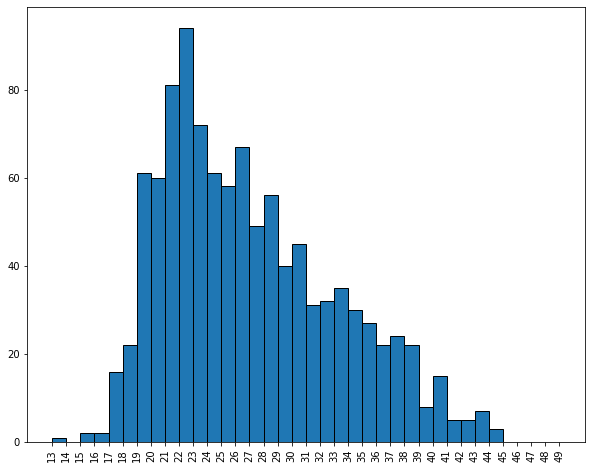

In [19]:
# Plot graph
plt.figure(figsize=(10,8))
plt.hist( plot_data, bins=ticks,edgecolor='black')
plt.xticks(ticks, rotation="vertical")

In [20]:
raw_data_no_outlier.describe()

,Year,Month,Day,Maximum temperature (Degree C),Z-Score
count,1053.000000,1053.0,1053.000000,1053.000000,1053.000000
mean,2006.488129,1.0,15.991453,26.997436,-0.002926
std,9.812457,0.0,8.948465,6.136296,0.995950
min,1990.000000,1.0,1.000000,13.900000,-2.128703
25%,1998.000000,1.0,8.000000,22.200000,-0.781573
50%,2006.000000,1.0,16.000000,25.900000,-0.181045
75%,2015.000000,1.0,24.000000,31.100000,0.662940
max,2023.000000,1.0,31.000000,44.600000,2.854054


## Data Cleaning - Adjusted Z-Score Method

In [21]:
raw_data['X minus median'] = raw_data['Maximum temperature (Degree C)'] - raw_data['Maximum temperature (Degree C)'].median()                    
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Z-Score,X minus median
0,1990,1,1,23.0,-0.651729,-2.9
1,1990,1,2,32.8,0.938858,6.9
2,1990,1,3,39.0,1.945148,13.1
3,1990,1,4,20.2,-1.106183,-5.7
4,1990,1,5,24.8,-0.359581,-1.1
...,...,...,...,...,...,...
1049,2023,1,27,28.9,0.305869,3.0
1050,2023,1,28,34.9,1.279698,9.0
1051,2023,1,29,23.9,-0.505655,-2.0
1052,2023,1,30,21.9,-0.830265,-4.0


In [22]:
raw_data['|X minus median|'] = abs(raw_data['Maximum temperature (Degree C)'] - raw_data['Maximum temperature (Degree C)'].median())                    
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Z-Score,X minus median,|X minus median|
0,1990,1,1,23.0,-0.651729,-2.9,2.9
1,1990,1,2,32.8,0.938858,6.9,6.9
2,1990,1,3,39.0,1.945148,13.1,13.1
3,1990,1,4,20.2,-1.106183,-5.7,5.7
4,1990,1,5,24.8,-0.359581,-1.1,1.1
...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,0.305869,3.0,3.0
1050,2023,1,28,34.9,1.279698,9.0,9.0
1051,2023,1,29,23.9,-0.505655,-2.0,2.0
1052,2023,1,30,21.9,-0.830265,-4.0,4.0


In [23]:
MAD = raw_data['|X minus median|'].median()
MAD

4.200000000000001

In [24]:
raw_data['Modified Z-Score'] = raw_data['X minus median']/MAD * 0.6745
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Z-Score,X minus median,|X minus median|,Modified Z-Score
0,1990,1,1,23.0,-0.651729,-2.9,2.9,-0.465726
1,1990,1,2,32.8,0.938858,6.9,6.9,1.108107
2,1990,1,3,39.0,1.945148,13.1,13.1,2.103798
3,1990,1,4,20.2,-1.106183,-5.7,5.7,-0.915393
4,1990,1,5,24.8,-0.359581,-1.1,1.1,-0.176655
...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,0.305869,3.0,3.0,0.481786
1050,2023,1,28,34.9,1.279698,9.0,9.0,1.445357
1051,2023,1,29,23.9,-0.505655,-2.0,2.0,-0.321190
1052,2023,1,30,21.9,-0.830265,-4.0,4.0,-0.642381


In [25]:
# Detecting outliers by looking at values with 3.5 standard deviations below or above median of the sample
raw_data[(raw_data['Modified Z-Score'] < -3.5) | (raw_data['Modified Z-Score'] > 3.5)]

,Year,Month,Day,Maximum temperature (Degree C),Z-Score,X minus median,|X minus median|,Modified Z-Score


In [26]:
print(raw_data['Modified Z-Score'].min())
print(raw_data['Modified Z-Score'].max())

-1.9271428571428562
3.227964285714285


## Data Transformation
### Log(x)

In [27]:
raw_data

,Year,Month,Day,Maximum temperature (Degree C),Z-Score,X minus median,|X minus median|,Modified Z-Score
0,1990,1,1,23.0,-0.651729,-2.9,2.9,-0.465726
1,1990,1,2,32.8,0.938858,6.9,6.9,1.108107
2,1990,1,3,39.0,1.945148,13.1,13.1,2.103798
3,1990,1,4,20.2,-1.106183,-5.7,5.7,-0.915393
4,1990,1,5,24.8,-0.359581,-1.1,1.1,-0.176655
...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,0.305869,3.0,3.0,0.481786
1050,2023,1,28,34.9,1.279698,9.0,9.0,1.445357
1051,2023,1,29,23.9,-0.505655,-2.0,2.0,-0.321190
1052,2023,1,30,21.9,-0.830265,-4.0,4.0,-0.642381


In [28]:
raw_data.drop(raw_data.columns[[4,5,6,7]], axis=1, inplace=True)
raw_data

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Year,Month,Day,Maximum temperature (Degree C)
0,1990,1,1,23.0
1,1990,1,2,32.8
2,1990,1,3,39.0
3,1990,1,4,20.2
4,1990,1,5,24.8
...,...,...,...,...
1049,2023,1,27,28.9
1050,2023,1,28,34.9
1051,2023,1,29,23.9
1052,2023,1,30,21.9


In [29]:
T_max_median = raw_data['Maximum temperature (Degree C)'].median()
T_max_median

25.9

In [30]:
# Taking log
base = 2
raw_data["Log T Max"] = np.emath.logn(base, raw_data["Maximum temperature (Degree C)"])
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Month,Day,Maximum temperature (Degree C),Log T Max
0,1990,1,1,23.0,4.523562
1,1990,1,2,32.8,5.035624
2,1990,1,3,39.0,5.285402
3,1990,1,4,20.2,4.336283
4,1990,1,5,24.8,4.632268
...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998
1050,2023,1,28,34.9,5.125155
1051,2023,1,29,23.9,4.578939
1052,2023,1,30,21.9,4.452859


In [31]:
raw_data['X minus mean'] = raw_data['Log T Max'] - raw_data['Log T Max'].mean()
log_mean = raw_data['Log T Max'].mean()
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean
0,1990,1,1,23.0,4.523562,-0.196166
1,1990,1,2,32.8,5.035624,0.315895
2,1990,1,3,39.0,5.285402,0.565674
3,1990,1,4,20.2,4.336283,-0.383445
4,1990,1,5,24.8,4.632268,-0.087460
...,...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998,0.133269
1050,2023,1,28,34.9,5.125155,0.405427
1051,2023,1,29,23.9,4.578939,-0.140790
1052,2023,1,30,21.9,4.452859,-0.266869


In [32]:
raw_data['Z-Score'] = (raw_data['Log T Max'] - raw_data['Log T Max'].mean())/ \
                       raw_data['Log T Max'].std()
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score
0,1990,1,1,23.0,4.523562,-0.196166,-0.613000
1,1990,1,2,32.8,5.035624,0.315895,0.987140
2,1990,1,3,39.0,5.285402,0.565674,1.767671
3,1990,1,4,20.2,4.336283,-0.383445,-1.198225
4,1990,1,5,24.8,4.632268,-0.087460,-0.273304
...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998,0.133269,0.416452
1050,2023,1,28,34.9,5.125155,0.405427,1.266916
1051,2023,1,29,23.9,4.578939,-0.140790,-0.439953
1052,2023,1,30,21.9,4.452859,-0.266869,-0.833939


In [33]:
# Detecting outliers by looking at values with 3 standard deviations below or above mean of the sample
raw_data[(raw_data['Z-Score'] < -3.0) | (raw_data['Z-Score'] > 3.0)]

,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score


In [34]:
raw_data['X minus median'] = raw_data['Log T Max'] - raw_data['Log T Max'].median()                    
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score,X minus median
0,1990,1,1,23.0,4.523562,-0.196166,-0.613000,-0.171318
1,1990,1,2,32.8,5.035624,0.315895,0.987140,0.340744
2,1990,1,3,39.0,5.285402,0.565674,1.767671,0.590522
3,1990,1,4,20.2,4.336283,-0.383445,-1.198225,-0.358597
4,1990,1,5,24.8,4.632268,-0.087460,-0.273304,-0.062612
...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998,0.133269,0.416452,0.158117
1050,2023,1,28,34.9,5.125155,0.405427,1.266916,0.430275
1051,2023,1,29,23.9,4.578939,-0.140790,-0.439953,-0.115941
1052,2023,1,30,21.9,4.452859,-0.266869,-0.833939,-0.242021


In [35]:
raw_data['|X minus median|'] = abs(raw_data['Log T Max'] - raw_data['Log T Max'].median())                    
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score,X minus median,|X minus median|
0,1990,1,1,23.0,4.523562,-0.196166,-0.613000,-0.171318,0.171318
1,1990,1,2,32.8,5.035624,0.315895,0.987140,0.340744,0.340744
2,1990,1,3,39.0,5.285402,0.565674,1.767671,0.590522,0.590522
3,1990,1,4,20.2,4.336283,-0.383445,-1.198225,-0.358597,0.358597
4,1990,1,5,24.8,4.632268,-0.087460,-0.273304,-0.062612,0.062612
...,...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998,0.133269,0.416452,0.158117,0.158117
1050,2023,1,28,34.9,5.125155,0.405427,1.266916,0.430275,0.430275
1051,2023,1,29,23.9,4.578939,-0.140790,-0.439953,-0.115941,0.115941
1052,2023,1,30,21.9,4.452859,-0.266869,-0.833939,-0.242021,0.242021


In [36]:
MAD = raw_data['|X minus median|'].median()
MAD

0.23565285946279468

In [37]:
raw_data['Modified Z-Score'] = raw_data['X minus median']/MAD * 0.6745
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score,X minus median,|X minus median|,Modified Z-Score
0,1990,1,1,23.0,4.523562,-0.196166,-0.613000,-0.171318,0.171318,-0.490358
1,1990,1,2,32.8,5.035624,0.315895,0.987140,0.340744,0.340744,0.975297
2,1990,1,3,39.0,5.285402,0.565674,1.767671,0.590522,0.590522,1.690228
3,1990,1,4,20.2,4.336283,-0.383445,-1.198225,-0.358597,0.358597,-1.026398
4,1990,1,5,24.8,4.632268,-0.087460,-0.273304,-0.062612,0.062612,-0.179212
...,...,...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998,0.133269,0.416452,0.158117,0.158117,0.452573
1050,2023,1,28,34.9,5.125155,0.405427,1.266916,0.430275,0.430275,1.231559
1051,2023,1,29,23.9,4.578939,-0.140790,-0.439953,-0.115941,0.115941,-0.331855
1052,2023,1,30,21.9,4.452859,-0.266869,-0.833939,-0.242021,0.242021,-0.692728


In [38]:
# Detecting outliers by looking at values with 3.5 standard deviations below or above median of the sample
raw_data[(raw_data['Modified Z-Score'] < -3.5) | (raw_data['Modified Z-Score'] > 3.5)]

,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score,X minus median,|X minus median|,Modified Z-Score


([<matplotlib.axis.XTick at 0x1ff3eddb708>,
 <a list of 42 Text xticklabel objects>)

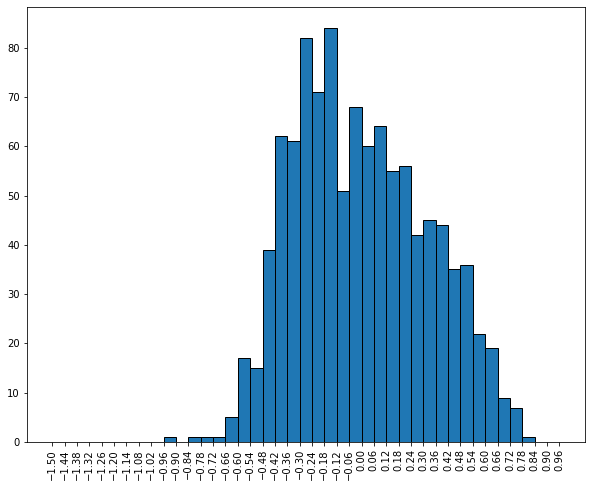

In [39]:
# plot graph
plot_data = raw_data['X minus mean']
ticks = list (np.arange(round(min(plot_data),0)-0.5, round(max(plot_data)+0.5,0), 0.06))
plt.figure(figsize=(10,8))
plt.hist( plot_data, bins=ticks,edgecolor='black')
plt.xticks(ticks, rotation="vertical")

In [40]:
# Save it as a variable
log_data = plot_data

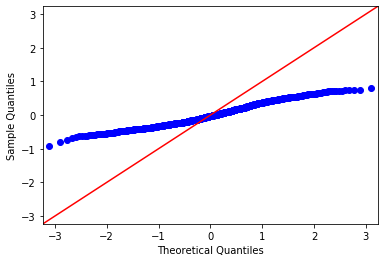

In [41]:
# QQ-Plot
sm.qqplot(plot_data, line ='45')
py.show()

In [42]:
log_data_summary=pd.DataFrame(
    {'Unadj_T_max':raw_data['Maximum temperature (Degree C)'],
       'log_T_max':raw_data['X minus mean']}
)
log_data_summary.describe()

,Unadj_T_max,log_T_max
count,1054.000000,1.054000e+03
mean,27.015465,-4.251290e-15
std,6.161247,3.200108e-01
min,13.900000,-9.227154e-01
25%,22.200000,-2.472406e-01
50%,25.900000,-2.484823e-02
75%,31.100000,2.391143e-01
max,46.000000,8.038335e-01


## Data Transformation
### X Root

In [43]:
raw_data

,Year,Month,Day,Maximum temperature (Degree C),Log T Max,X minus mean,Z-Score,X minus median,|X minus median|,Modified Z-Score
0,1990,1,1,23.0,4.523562,-0.196166,-0.613000,-0.171318,0.171318,-0.490358
1,1990,1,2,32.8,5.035624,0.315895,0.987140,0.340744,0.340744,0.975297
2,1990,1,3,39.0,5.285402,0.565674,1.767671,0.590522,0.590522,1.690228
3,1990,1,4,20.2,4.336283,-0.383445,-1.198225,-0.358597,0.358597,-1.026398
4,1990,1,5,24.8,4.632268,-0.087460,-0.273304,-0.062612,0.062612,-0.179212
...,...,...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,4.852998,0.133269,0.416452,0.158117,0.158117,0.452573
1050,2023,1,28,34.9,5.125155,0.405427,1.266916,0.430275,0.430275,1.231559
1051,2023,1,29,23.9,4.578939,-0.140790,-0.439953,-0.115941,0.115941,-0.331855
1052,2023,1,30,21.9,4.452859,-0.266869,-0.833939,-0.242021,0.242021,-0.692728


In [44]:
raw_data.drop(raw_data.columns[[4,5,6,7,8,9]], axis=1, inplace=True)
raw_data

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Year,Month,Day,Maximum temperature (Degree C)
0,1990,1,1,23.0
1,1990,1,2,32.8
2,1990,1,3,39.0
3,1990,1,4,20.2
4,1990,1,5,24.8
...,...,...,...,...
1049,2023,1,27,28.9
1050,2023,1,28,34.9
1051,2023,1,29,23.9
1052,2023,1,30,21.9


In [45]:
# Taking X root
x = 1.7
raw_data["X Root"] = raw_data["Maximum temperature (Degree C)"] ** (1/x)
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Month,Day,Maximum temperature (Degree C),X Root
0,1990,1,1,23.0,6.324357
1,1990,1,2,32.8,7.792746
2,1990,1,3,39.0,8.628203
3,1990,1,4,20.2,5.859408
4,1990,1,5,24.8,6.610978
...,...,...,...,...,...
1049,2023,1,27,28.9,7.233553
1050,2023,1,28,34.9,8.082475
1051,2023,1,29,23.9,6.468779
1052,2023,1,30,21.9,6.144641


In [46]:
raw_data['X minus mean'] = raw_data["X Root"] - raw_data["X Root"].mean()
x_root_mean = raw_data["X Root"].mean()
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean
0,1990,1,1,23.0,6.324357,-0.585698
1,1990,1,2,32.8,7.792746,0.882691
2,1990,1,3,39.0,8.628203,1.718149
3,1990,1,4,20.2,5.859408,-1.050646
4,1990,1,5,24.8,6.610978,-0.299077
...,...,...,...,...,...,...
1049,2023,1,27,28.9,7.233553,0.323499
1050,2023,1,28,34.9,8.082475,1.172420
1051,2023,1,29,23.9,6.468779,-0.441276
1052,2023,1,30,21.9,6.144641,-0.765413


In [47]:
raw_data['Z-Score'] = (raw_data["X Root"] - raw_data["X Root"].mean())/ \
                       raw_data["X Root"].std()
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean,Z-Score
0,1990,1,1,23.0,6.324357,-0.585698,-0.639143
1,1990,1,2,32.8,7.792746,0.882691,0.963238
2,1990,1,3,39.0,8.628203,1.718149,1.874932
3,1990,1,4,20.2,5.859408,-1.050646,-1.146519
4,1990,1,5,24.8,6.610978,-0.299077,-0.326368
...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,7.233553,0.323499,0.353018
1050,2023,1,28,34.9,8.082475,1.172420,1.279406
1051,2023,1,29,23.9,6.468779,-0.441276,-0.481543
1052,2023,1,30,21.9,6.144641,-0.765413,-0.835258


In [48]:
# Detecting outliers by looking at values with 3 standard deviations below or above mean of the sample
raw_data[(raw_data['Z-Score'] < -3.0) | (raw_data['Z-Score'] > 3.0)]

,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean,Z-Score


In [49]:
raw_data['X minus median'] = raw_data["X Root"] - raw_data["X Root"].median()                    
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean,Z-Score,X minus median
0,1990,1,1,23.0,6.324357,-0.585698,-0.639143,-0.457565
1,1990,1,2,32.8,7.792746,0.882691,0.963238,1.010823
2,1990,1,3,39.0,8.628203,1.718149,1.874932,1.846281
3,1990,1,4,20.2,5.859408,-1.050646,-1.146519,-0.922514
4,1990,1,5,24.8,6.610978,-0.299077,-0.326368,-0.170944
...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,7.233553,0.323499,0.353018,0.451631
1050,2023,1,28,34.9,8.082475,1.172420,1.279406,1.300553
1051,2023,1,29,23.9,6.468779,-0.441276,-0.481543,-0.313143
1052,2023,1,30,21.9,6.144641,-0.765413,-0.835258,-0.637281


In [50]:
raw_data['|X minus median|'] = abs(raw_data["X Root"] - raw_data["X Root"].median())                    
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean,Z-Score,X minus median,|X minus median|
0,1990,1,1,23.0,6.324357,-0.585698,-0.639143,-0.457565,0.457565
1,1990,1,2,32.8,7.792746,0.882691,0.963238,1.010823,1.010823
2,1990,1,3,39.0,8.628203,1.718149,1.874932,1.846281,1.846281
3,1990,1,4,20.2,5.859408,-1.050646,-1.146519,-0.922514,0.922514
4,1990,1,5,24.8,6.610978,-0.299077,-0.326368,-0.170944,0.170944
...,...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,7.233553,0.323499,0.353018,0.451631,0.451631
1050,2023,1,28,34.9,8.082475,1.172420,1.279406,1.300553,1.300553
1051,2023,1,29,23.9,6.468779,-0.441276,-0.481543,-0.313143,0.313143
1052,2023,1,30,21.9,6.144641,-0.765413,-0.835258,-0.637281,0.637281


In [51]:
MAD = raw_data['|X minus median|'].median()
MAD

0.6538009403947971

In [52]:
raw_data['Modified Z-Score'] = raw_data['X minus median']/MAD * 0.6745
raw_data

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean,Z-Score,X minus median,|X minus median|,Modified Z-Score
0,1990,1,1,23.0,6.324357,-0.585698,-0.639143,-0.457565,0.457565,-0.472052
1,1990,1,2,32.8,7.792746,0.882691,0.963238,1.010823,1.010823,1.042826
2,1990,1,3,39.0,8.628203,1.718149,1.874932,1.846281,1.846281,1.904733
3,1990,1,4,20.2,5.859408,-1.050646,-1.146519,-0.922514,0.922514,-0.951720
4,1990,1,5,24.8,6.610978,-0.299077,-0.326368,-0.170944,0.170944,-0.176356
...,...,...,...,...,...,...,...,...,...,...
1049,2023,1,27,28.9,7.233553,0.323499,0.353018,0.451631,0.451631,0.465929
1050,2023,1,28,34.9,8.082475,1.172420,1.279406,1.300553,1.300553,1.341728
1051,2023,1,29,23.9,6.468779,-0.441276,-0.481543,-0.313143,0.313143,-0.323057
1052,2023,1,30,21.9,6.144641,-0.765413,-0.835258,-0.637281,0.637281,-0.657457


In [53]:
# Detecting outliers by looking at values with 3.5 standard deviations below or above median of the sample
raw_data[(raw_data['Modified Z-Score'] < -3.5) | (raw_data['Modified Z-Score'] > 3.5)]

,Year,Month,Day,Maximum temperature (Degree C),X Root,X minus mean,Z-Score,X minus median,|X minus median|,Modified Z-Score


([<matplotlib.axis.XTick at 0x1ff3f0fd288>,
 <a list of 17 Text xticklabel objects>)

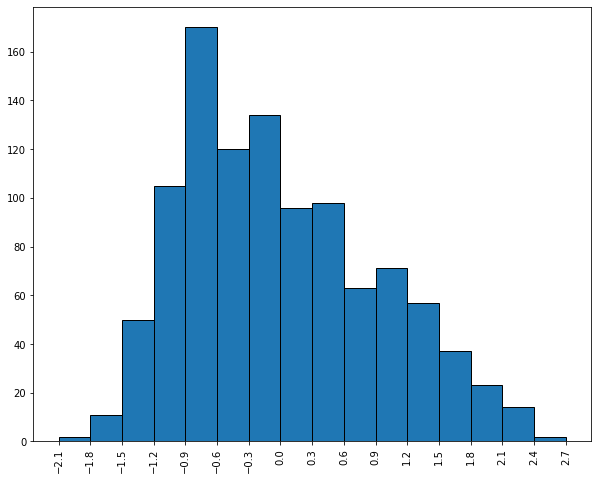

In [54]:
# plot graph
plot_data = raw_data["X minus mean"]
ticks = list (np.arange(round(min(plot_data),0)-0.1, round(max(plot_data)+0.6,0), 0.3))
plt.figure(figsize=(10,8))
plt.hist( plot_data, bins=ticks,edgecolor='black')
plt.xticks(ticks, rotation="vertical")

In [55]:
# Save it as a variable
x_root_data = plot_data

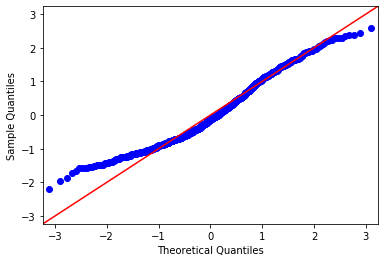

In [56]:
# QQ-Plot
sm.qqplot(plot_data, line ='45')
py.show()

In [57]:
X_root_data_summary=pd.DataFrame(
    {
        'Unadj_T_max':raw_data['Maximum temperature (Degree C)'],
        'X_root_T_max':raw_data['X minus mean']
    }
)
X_root_data_summary.describe()

,Unadj_T_max,X_root_T_max
count,1054.000000,1.054000e+03
mean,27.015465,-1.403052e-14
std,6.161247,9.163790e-01
min,13.900000,-2.207199e+00
25%,22.200000,-7.160383e-01
50%,25.900000,-1.281323e-01
75%,31.100000,6.425083e-01
max,46.000000,2.598026e+00


## Box-Cox Transformation

Lambda value used for Transformation: -0.521761065747713


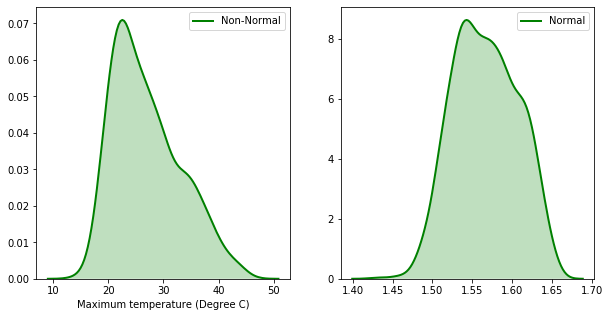

In [58]:
# generate non-normal data (exponential)
original_data = raw_data['Maximum temperature (Degree C)']
 
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(original_data)
 
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(original_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
 
print(f"Lambda value used for Transformation: {fitted_lambda}")

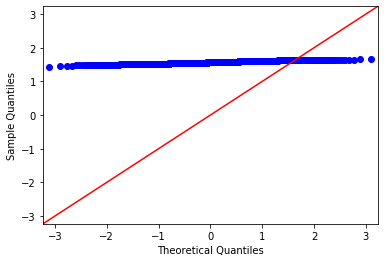

In [59]:
# QQ-Plot
sm.qqplot(fitted_data, line ='45')
py.show()

In [60]:
# Normality Test - Shapiro-Wilk Test Summary
print( "fitted_data: ",
       shapiro(fitted_data))

fitted_data:  (0.9861882925033569, 2.0009871093407128e-08)


In [61]:
# Normality Test - Kolmogorov-Smirnov Test Summary
print( "fitted_data: ",
       kstest(fitted_data,"norm"))

fitted_data:  KstestResult(statistic=0.9265444045622987, pvalue=0.0)


In [62]:
comparison_summary = pd.DataFrame(
    {
        'Unadj_T_max':unadj_data,
        'Log_T_max':log_data,
        'X_root_T_max':x_root_data,
        'Fitted_T_max':fitted_data
    }
)
comparison_summary.describe()

,Unadj_T_max,Log_T_max,X_root_T_max,Fitted_T_max
count,1054.000000,1.054000e+03,1.054000e+03,1054.000000
mean,27.015465,-4.251290e-15,-1.403052e-14,1.566563
std,6.161247,3.200108e-01,9.163790e-01,0.039959
min,13.900000,-9.227154e-01,-2.207199e+00,1.431133
25%,22.200000,-2.472406e-01,-7.160383e-01,1.536350
50%,25.900000,-2.484823e-02,-1.281323e-01,1.565734
75%,31.100000,2.391143e-01,6.425083e-01,1.597679
max,46.000000,8.038335e-01,2.598026e+00,1.656590


In [63]:
# Normality Test - Shapiro-Wilk Test Summary

print( "Unadjusted Data : ",
       shapiro(unadj_data))

print( "Log_T_max Data: ",
       shapiro(log_data))

print( "X_root_T_max Data : ",
       shapiro(x_root_data))
      
print( "fitted_data: ",
       shapiro(fitted_data))

Unadjusted Data :  (0.9538675546646118, 1.0905597172374645e-17)
Log_T_max Data:  (0.981287956237793, 2.1279220052683456e-10)
X_root_T_max Data :  (0.9678550958633423, 1.6349226659995164e-14)
fitted_data:  (0.9861882925033569, 2.0009871093407128e-08)


In [64]:
# Normality Test - Kolmogorov-Smirnov Test Summary

print( "Unadjusted Data : ",
       kstest(unadj_data,"norm"))

print( "Log_T_max Data : ",
       kstest(log_data,"norm"))

print( "X_root_T_max Data: ",
       kstest(x_root_data,"norm"))
      
print( "fitted_data: ",
       kstest(fitted_data,"norm"))

Unadjusted Data :  KstestResult(statistic=1.0, pvalue=0.0)
Log_T_max Data :  KstestResult(statistic=0.2777374876335605, pvalue=2.2472506157951777e-72)
X_root_T_max Data:  KstestResult(statistic=0.07053200575958546, pvalue=5.273915168605189e-05)
fitted_data:  KstestResult(statistic=0.9265444045622987, pvalue=0.0)


In [65]:
# Percentile Summary
pct = 95

print( str(pct) + "th percentile of Unadj_T_max : ",
       np.percentile(unadj_data,pct))

print( str(pct) + "th percentile of Log_T_max : ",
       np.percentile(log_data,pct))

print( str(pct) + "th percentile of X_root_T_max : ",
       np.percentile(x_root_data,pct))
     
print( str(pct) + "th percentile of fitted_data : ",
        (np.percentile(fitted_data,pct)) )

95th percentile of Unadj_T_max :  38.5
95th percentile of Log_T_max :  0.5470581198321378
95th percentile of X_root_T_max :  1.6529063738135452
95th percentile of fitted_data :  1.6312894517849101


In [66]:
# Equivalent values calculation

print( str(pct) + "th percentile of Unadj_T_max : ",
       np.percentile(unadj_data,pct))

print( str(pct) + "th percentile of Log_T_max : ",
       base ** (np.percentile(log_data,pct) + log_mean),
       "where log base = " + str (base) )

print( str(pct) + "th percentile of X_root_T_max : ",
       (np.percentile(x_root_data,pct) + x_root_mean) ** x,
        "where x root = " + str (x) )

print( str(pct) + "th percentile of fitted_data for T_max : ",
    10**(np.emath.logn(10,(np.percentile(fitted_data,pct) * fitted_lambda + 1))/fitted_lambda),
     "where lambda =" + str(fitted_lambda))

95th percentile of Unadj_T_max :  38.5
95th percentile of Log_T_max :  38.500000000000014 where log base = 2
95th percentile of X_root_T_max :  38.5 where x root = 1.7
95th percentile of fitted_data for T_max :  38.49999999999999 where lambda =-0.521761065747713
